<a href="https://colab.research.google.com/github/pargaw/pyCt/blob/main/GP_Model_Code_for_Discrepancies_in_Epidemiological_Modeling_of_Aggregated_Heterogeneous_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GP Model Code for *Discrepancies in Epidemiological Modeling of Aggregated Heterogeneous Data*
---

In [ ]:
pip install --upgrade pymc3

In [1]:
# initalize tools
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import matplotlib.pyplot as plt
from pymc3 import model_to_graphviz, Model
from google.colab import files

np.random.seed(123)

In [ ]:
print(pm.__version__)

3.11.2


## Inferring Epidemic Trajectory Using Multiple Cross-Sections
---
We model the variation in observed Ct values arising from individual-level viral growth and estimate the distribution of observed Ct values as a function of times since infection. We then use this function to estimate the epidemic growth rate conditional on a set of observed Ct values. 

We are given a multiple cross-sections of RT-qPCR test results. We combine 

1. The likelihood of observing a Ct value on having been infected on a given day

2. The likelihood of being infected on a given date prior to the sample date.

### 1. Ct Value Model
---
The mathematical model that describes the distribution of observed SARS-CoV-2 viral loads over time following infection. They use a parametric model describing the the modal Ct value, $C_{mode}(a)$ for an individual $a$ days after infection.

Since they are interested in a population-level distribution and not individual trajetctories, they put a **Gumbel distribution** prior on the observed $Ct$ values with mean $C_{mode}(a) - \sigma(a)\gamma$, and variance $\frac{\sigma(a)^2\pi^2}{6}$ where $\gamma$ is Euler's constant.

#### Why a Gumbel Distribution?
---
* $f(x; \mu, \beta) = \frac{1}{\beta}e^{-(z + e^{-z})}$ where $z = \frac{x - \mu}{\beta}$.
* used to model the distribution of the maximum or minimum number of samples of various distributions.
* Captures the variation resulting from both swabbing variability and inidividual-level difference in viral kinetics.
* Captures overdispersion of high measured Ct values.
* We write $C(a) \sim Gumbel(C_{mode}(a), \sigma(a))$.

In [ ]:
# calculates the modal Ct value according to two-hinge function
# specified on pg.3 of the supplementary material
# init values as specified on pg. 30 of suppementary material
c_zero = 40
c_peak = 19.73598747
c_switch = 38.0
t_eclipse = 0.0
# global limit of detection variable
c_LOD = 40.0
t_peak = 5.0
t_switch = 13.29211948
# limit of detection (inf/max integer values)
t_LOD = 2147483647
# daily probability of individual fully cleraing virus
# and becoming undectable
p_addl = 0.103299323

def calculate_c_mode(a):
  # undetectable true value
  if (a <= t_eclipse):
    return c_zero
  # log viral load increases
  elif (t_eclipse < a and a <= t_eclipse + t_peak):
    return c_zero + (c_peak - c_zero)/(t_peak) * (a - t_eclipse)
  # log viral load wanes
  elif (t_eclipse + t_peak < a and a <= t_eclipse + t_peak + t_switch):
    return c_peak + (c_switch - c_peak)/(t_switch) * (a - t_eclipse - t_peak)
  # log viral load wanes at a slower linear rate
  else:
    return c_switch + (c_LOD - c_switch)/(t_LOD - t_switch - t_peak - t_eclipse) * (a - t_eclipse - t_peak - t_switch)

In [ ]:
# calculates scale parameter sigma_a
# init values
sigma_obs = 5.0
s_mod = 0.788828786
t_mod = 14.0

def calculate_sigma(a):
  if (a < t_eclipse + t_peak + t_switch):
    return sigma_obs
  elif (t_eclipse + t_peak + t_switch <= a and a < t_eclipse + t_peak + t_switch + t_mod):
    return sigma_obs * (1 - (((1 - s_mod)/t_mod) * (a - t_eclipse - t_peak - t_switch)))
  else:
    return sigma_obs * s_mod

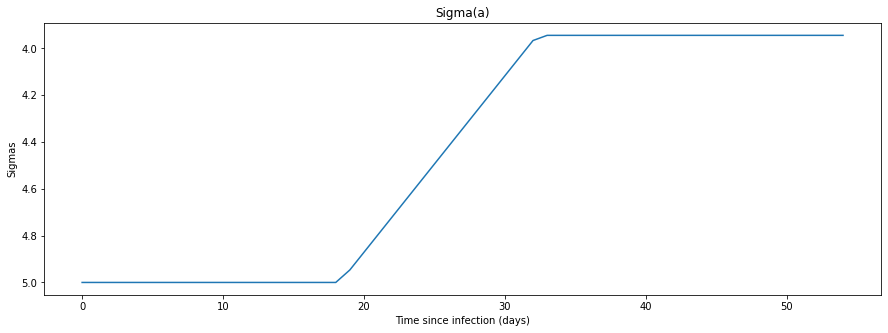

In [ ]:
# visual sanity check for Ct simulations
# calculate
a_s = np.array(range(55))
sigmas = np.array([calculate_sigma(a) for a in a_s])

# plots
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(a_s, sigmas)
ax.set_xlabel("Time since infection (days)")
ax.set_ylabel("Sigmas")
ax.set_title("Sigma(a)")
# inverts axis
plt.gca().invert_yaxis()

plt.show()

In [ ]:
# samples C(a)
def sample_C(a, no_variance=True):
  mean = calculate_c_mode(a)
  if (no_variance):
    variance = 0
  else:
    variance = calculate_sigma(a)
  return sp.stats.gumbel_r.rvs(mean, variance)

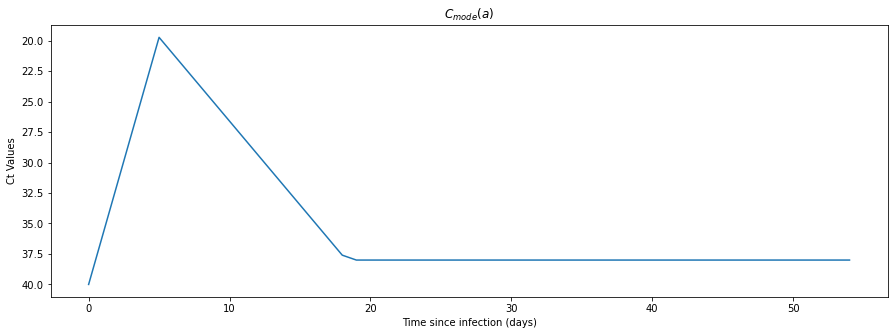

In [ ]:
# visual sanity check for Ct simulations
# calculate
a_s = np.array(range(55))
# ct_samples = np.array([[sample_C(a, no_variance=False) for a in a_s] for i in range(100)])
cts = np.array([sample_C(a) for a in a_s])
# plots
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(a_s, cts)
# for ct in ct_samples:
#   # plot prevalence
#   ax.plot(a_s, ct)
ax.set_xlabel("Time since infection (days)")
ax.set_ylabel("Ct Values")
ax.set_title("$C_{mode}(a)$")
# inverts axis
plt.gca().invert_yaxis()

plt.show()

In [ ]:
def gumbel_pdf(x, mean, variance):
  y = (x - mean) / variance
  pdf = np.exp(-(y + np.exp(-y)))
  return pdf / variance

# cdf of gumbel ct distribution
def cdf_a(a, limit):
  mean = calculate_c_mode(a)
  variance = calculate_sigma(a)
  return sp.stats.gumbel_r.cdf(limit, mean, variance)

# pdf of gumbel ct distribution
# p_a is a function calculating the probability that an individuals Ct value is X_i at day t - a
# we don't use the SCIPY package sp.stats.gumbel_r.pdf(x, mean, variance) because it won't
# work with Pymc3
def p_a_multi(a, x):
  mode = calculate_c_mode(a)
  sigma = calculate_sigma(a)
  normalizer = cdf_a(a, c_LOD) - cdf_a(a, 0)
  result = gumbel_pdf(x, mode, sigma) / normalizer

  return result

In [ ]:

# phi_a is a function calculating the probability that a Ct value is detectable a days after infection
def phi_a(a):
  prob_ca_leq_clod = cdf_a(a, c_LOD)
  if (a <= t_eclipse + t_peak + t_switch):
    return prob_ca_leq_clod
  else:
    return prob_ca_leq_clod * (1 - p_addl) ** (a - t_eclipse - t_peak - t_switch)

Text(0.5, 1.0, 'Phi of Ct Value')

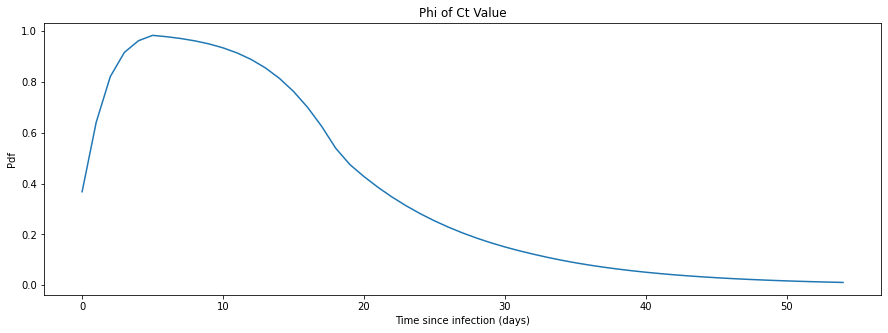

In [ ]:
# visual check for phi_a
phis = np.array([phi_a(a) for a in a_s])

# plots
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# plot pdf
ax.plot(a_s, phis)
ax.set_xlabel("Time since infection (days)")
ax.set_ylabel("Pdf")
ax.set_title("Phi of Ct Value")

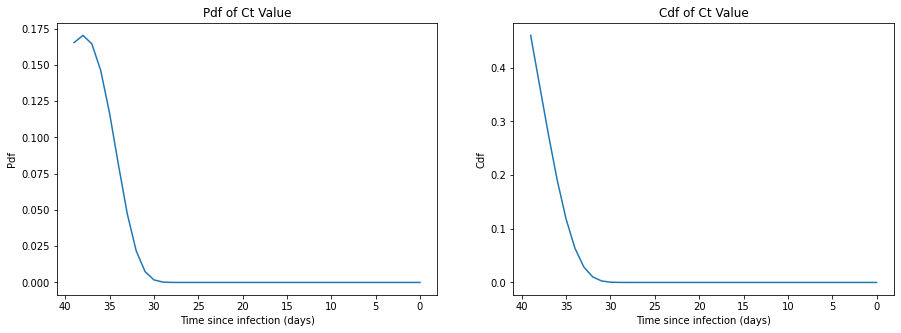

In [ ]:
# visual sanity check for Ct simulations
# calculate
xs = np.array(range(40))
pdfs = np.array([p_a_multi(35, x) for x in xs])
cdfs = np.array([cdf_a(35, lim) for lim in xs])

# plots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# plot pdf
ax[0].plot(xs, pdfs)
ax[0].set_xlabel("Time since infection (days)")
ax[0].set_ylabel("Pdf")
ax[0].set_title("Pdf of Ct Value")
ax[0].invert_xaxis()
# plot cdf
ax[1].plot(xs, cdfs)
ax[1].set_xlabel("Time since infection (days)")
ax[1].set_ylabel("Cdf")
ax[1].set_title("Cdf of Ct Value")
ax[1].invert_xaxis()


plt.show()

## Likelihood of Daily Probability of Infection
---
For testing day $t$: let $\pi_{t - a} := $probability that a randomly-selected individual in the population was infected on day $t - a$.

Therefore, let $\pi_{t - A_{max}},...,\pi_{t - 1}$ be the daily probabilities of infection for the whole population for $A_{max}$ days to 1 day prior to testing day $t$.

Let $p_a(x) :=$ probability that the Ct value is $x$ for a test conducted $a$ days after infection. 

Let $\phi_a :=$ probability of a Ct value being detectable $a$ days after infection.

Let PCR test results from a sample of $n$ individuals be recorded $X_1,...,X_n$.

Then, for $x_i \leq C_{LOD}$ (a detectable Ct value): 

**The probability of individual $i$ having Ct value $x_i$** is:

$$
P(X_i = x_i | \pi_{t - A_{max}},..,\pi_{t - 1}) = \sum_{a = 1}^{A_{max}} p_a(x_i)\pi_{t - a}
$$

(a sum of days before test of probability of having Ct value on day $t - a$ and probability of being infected on day $t - a$)

**The probability of a randomly-chosen individual being detectable to PCR on testing day $t$** is:

$$
P(X_i \leq C_{LOD} | \pi_{t - A_{max}},..,\pi_{t - 1}) = \sum_{a = 1}^{A_{max}} \phi_a\pi_{t - a}
$$

**The likelihood for the $n$ PCR values** is:

$$
\mathcal{L}(\pi_{t - A_{max}},...,\pi_{t - a} | X_1,...,X_n) = \prod_{i = 1}^n \bigg[ \bigg(\sum_{a = 1}^{A_{max}} p_a(X_i) * \phi_a * \pi_{t - a}\bigg)^{\mathbb{I}(X_i \leq C_{LOD})} \bigg( 1 - \sum_{a = 1}^{A_{max}}\phi_a\pi_{t - a}\bigg)^{\mathbb{I}(X_i > C_{LOD})} \bigg]
$$

This is the probability that data point $i$ has detectable Ct value $X_i$ if they are detectable or probability of being not detectable if not detectable, for all data points.

This likelihood can be maximized to get nonparametric estimates of the daily probability of infection with constraint $\sum_{a = 1}^{A_{max}} \pi_{t - a} \leq 1$

Therefore the log likelihood is:

$$
\log \mathcal{L}(\pi_{t - A_{max}},...,\pi_{t - a} | X_1,...,X_n) = \log \prod_{i = 1}^n \bigg[ \bigg(\sum_{a = 1}^{A_{max}} p_a(X_i) * \phi_a * \pi_{t - a}\bigg)^{\mathbb{I}(X_i \leq C_{LOD})} \bigg( 1 - \sum_{a = 1}^{A_{max}}\phi_a\pi_{t - a}\bigg)^{\mathbb{I}(X_i > C_{LOD})} \bigg]
$$

$$
= \sum_{i = 1}^n \log \bigg[ \bigg(\sum_{a = 1}^{A_{max}} p_a(X_i) * \phi_a * \pi_{t - a}\bigg)^{\mathbb{I}(X_i \leq C_{LOD})} \bigg( 1 - \sum_{a = 1}^{A_{max}}\phi_a\pi_{t - a}\bigg)^{\mathbb{I}(X_i > C_{LOD})} \bigg]
$$

$$
= \sum_{i = 1}^n \log \bigg(\sum_{a = 1}^{A_{max}} p_a(X_i) * \phi_a * \pi_{t - a}\bigg)^{\mathbb{I}(X_i \leq C_{LOD})} + \log \bigg( 1 - \sum_{a = 1}^{A_{max}}\phi_a\pi_{t - a}\bigg)^{\mathbb{I}(X_i > C_{LOD})}
$$

$$
= \sum_{i = 1}^n \mathbb{I}(X_i \leq C_{LOD}) * \log \bigg(\sum_{a = 1}^{A_{max}} p_a(X_i) * \phi_a * \pi_{t - a}\bigg) + \mathbb{I}(X_i > C_{LOD}) * \log \bigg( 1 - \sum_{a = 1}^{A_{max}}\phi_a\pi_{t - a}\bigg)
$$

$$
= \sum_{i, X_i \leq C_{LOD}} \log \bigg(\sum_{a = 1}^{A_{max}} p_a(X_i) * \phi_a * \pi_{t - a}\bigg) + \sum_{i, X_i > C_{LOD}} \log \bigg( 1 - \sum_{a = 1}^{A_{max}}\phi_a\pi_{t - a}\bigg)
$$

$$
= \sum_{i, X_i \leq C_{LOD}} \log \bigg(\sum_{a = 1}^{A_{max}} p_a(X_i) * \phi_a * \pi_{t - a}\bigg) + |\{X_i | X_i > C_{LOD} \}| * \log \bigg( 1 - \sum_{a = 1}^{A_{max}}\phi_a\pi_{t - a}\bigg)
$$

### Likelihood for Only Detectable Ct Values
---

In [ ]:
# x is a single data point
# A_max is the maximum number of days before test day that we consider
# probs is a function that outputs the probability of daily incidence
def calculate_prob(x, A_max, probs):
  result = 0
  # we need to keep a sum of the probabilities in order to calculate an
  # actual probability. right now probs returns a real value
  # probs_sum = 0
  for a in range(A_max):
    result += p_a_multi(a, x) * phi_a(a) * probs(a)
  return result

# A_max is the maximum number of days before test day that we consider
# probs is a function that outputs the probability of daily incidence
def calculate_detectable_prob(A_max, probs):
  result = 0
  for a in range(A_max):
    result += phi_a(a) * probs(a)
  return result

In [ ]:
def compute_ct_likelihood_observable(X, stop_time, prob_func):
  logprob = np.log(calculate_detectable_prob(stop_time, prob_func))
  n = X.size
  sum = pm.math.sum(np.log(calculate_prob(X, stop_time, prob_func)))
  return sum - n * logprob 

### Likelihood for All Ct Values
---

In [ ]:
# A_max is the maximum number of days before test day that we consider
# probs is a function that outputs the probability of daily incidence
def calculate_undetectable_prob(A_max, probs):
  return 1 - calculate_detectable_prob(A_max, probs)

def compute_ct_likelihood_all(detectableX, num_undetectable, stop_time, prob_func):
  undetectable_logprob = np.log(calculate_undetectable_prob(stop_time, prob_func))
  sum = pm.math.sum(np.log(calculate_prob(detectableX, stop_time, prob_func)))
  # likelihood of detectables + likelihood of undetectables
  return sum + num_undetectable * undetectable_logprob

#### Code for Posterior Sampler of Exponential Model
---
We use the Pymc3 software's custom distribution API found [here](https://docs.pymc.io/Probability_Distributions.html#custom-distributions)

In [ ]:
# draw graphical model for the thing we just defined  
def draw_model(pymc3_model):
  model_to_graphviz(pymc3_model)

In [ ]:
# plots traceplots as a sanity check
def plot_trace(samples):
  fig, ax = plt.subplots(1, 1, figsize=(10, 5))
  ax.plot(range(len(samples)), samples, color='orange', alpha=0.5)
  ax.set_title('trace plot')

  plt.show()

In [ ]:
# sanity check for confidence intervals
def compute_confidence_intervals(user_samples):
  # one per user
  ubs = []
  lbs = []
  for samples in user_samples:
    ubs.append(np.percentile(samples, 97.5, axis = 0))
    lbs.append(np.percentile(samples, 2.5, axis = 0))
  return ubs, lbs

### Comparison with True Rates
---

In [ ]:
def daily_growth_rate(inc_t, inc_t1):
  return np.log(inc_t1 / inc_t)

def generate_true_rates(incidences, test_times):
  true_rates = []
  # calculates true growth rate value from simulation outputs
  for time in test_times:
    # calculate average growth rate
    # look at average growth rate in the 35-day period
    current_growth_rate = np.mean([daily_growth_rate(incidences[time - i] / N, incidences[time - i + 1] / N) for i in range(A_max)])
    true_rates.append(current_growth_rate)

## Gaussian Process Prior Model
---
The GP prior for the incidence rate is $\pi(t) = (1 + e^{-k(t)})^{-1}$ where $k \sim MVN(\mathbf{0}, \mathbf{K})$ where $\mathbf{K}$ is the kernel function given by $\mathbf{K}_{ij} = \eta^2 \exp(-\rho^2D_{ij}^2)$ where $D_{ij}$ is the difference between $i$ and $j$. Notice $\mathbf{K}$ is a squared exponential (SE) kernel with hyperparameters $\eta$ (signal variance), $\rho$ (inverse-length scale).

We tune hyperparameters using Type-II ML as a standard.

$i$ and $j$ times from test time $t$ to $t - A_{max}$.

multiple cross section likelihood is just:

$$log p_{t = 55}(beta | X blah) + log p_{t = 68}(beta | X blah) + ....$$

with starting time is $t_0 = 20$ because $t_0$ is always first time stamp - $A_{max}$

Intuition: So we're trying to formalize that logic. We are saying "given that we've observed a bunch of Ct values today, t, what was the probability of infection on each day in the past?".

In [ ]:
# return pi_{t - a}, k is the GP function, vector length last test time
def pi_a(k):
  return 1 / (1 + np.exp(-k))

In [ ]:
# each entry of the resulting vector is a probability
def calculate_gp_vector(k, pi0=1):
  result = pi_a(k)
  total_sum = pm.math.sum(result)
  return pi0 * (result / total_sum)

In [ ]:
# for the GP model, we always set t = t' - t0 where t0 is determined by
# first time stamp t' - A_max
# k is a vector of length A_max
# X is observed ct values
# times is the time stamp days we are considering
def compute_GP_log_likelihood(k, X, stop_time):
  gp_probs_vector = calculate_gp_vector(k)
  gp_prob = lambda a: gp_probs_vector[stop_time - 1 - a]
  return compute_ct_likelihood_observable(X, stop_time, gp_prob)

# likelihood for the gp model
# X contains both detectable and undectable values
def compute_GP_log_likelihood_all(k, pi0, detectableX, num_undetectable, stop_time):
  gp_probs_vector = calculate_gp_vector(k, pi0)
  gp_prob = lambda a: gp_probs_vector[stop_time - 1 - a]
  return compute_ct_likelihood_all(detectableX, num_undetectable, stop_time, gp_prob)

In [ ]:
# this is hard coded and assumes the first infection day is 20
def compute_log_likelihood_multiple_sections(f, Xs, test_times, split_indices):
  sum = 0.0
  num_sections = len(test_times)
  for i in range(num_sections):
    stop_time = int(test_times[i] - 20)
    ct_start = int(split_indices[i])
    ct_end = int(split_indices[i + 1])
    current_cts = Xs[range(ct_start, ct_end)]
    sum += compute_GP_log_likelihood(f[range(stop_time)].flatten(), current_cts, stop_time)
  return sum

# THIS IS ALSO WRONG
# THERE IS ONLY ONE pi0!!!! 
def compute_log_likelihood_multiple_sections_all(f, pi0, Xs, num_undetectables, test_times, split_indices):
  sum = 0.0
  num_sections = len(test_times)
    # instead of passing in f to the likelihood
    # we first transform f using the same pi0 and then
  for i in range(num_sections):
    # pass in subsections of transformed f into likelihood
    stop_time = int(test_times[i] - 20)
    ct_start = int(split_indices[i])
    ct_end = int(split_indices[i + 1])
    current_cts = Xs[range(ct_start, ct_end)]
    sum += compute_GP_log_likelihood_all(f[range(stop_time)].flatten(), pi0, current_cts, num_undetectables[i], stop_time)
  return sum

In [ ]:
## JUST FOR SANITY CHECK ##
def compute_ct_likelihood_numpy(X, stop_time, prob_func):
  logprob = np.log(calculate_detectable_prob(stop_time, prob_func))
  n = X.size
  sum = np.sum(np.log(calculate_prob(X, stop_time, prob_func)))
  return sum - n * logprob 

# each entry of the resulting vector is a probability
def alt_gp_vector(k, pi0=1):
  result = pi_a(k)
  total_sum = np.sum(result)
  return pi0 * (result / total_sum)

def alt_gp_likelihood(k, X, stop_time):
  gp_probs_vector = alt_gp_vector(k)
  gp_prob = lambda a: gp_probs_vector[stop_time - 1 - a]
  logprob = np.log(calculate_detectable_prob(stop_time, gp_prob))
  n = X.size
  sum = np.sum(np.log(calculate_prob(X, stop_time, gp_prob)))
  return sum - n * logprob

def alt_gp_likelihood_all(k, pi0, X, num_undetectables, stop_time):
  gp_probs_vector = alt_gp_vector(k, pi0)
  gp_prob = lambda a: gp_probs_vector[stop_time - 1 - a]
  logprob = np.log(1 - calculate_detectable_prob(stop_time, gp_prob))
  sum = np.sum(np.log(calculate_prob(X, stop_time, gp_prob)))
  return sum + num_undetectables * logprob

def alt_multiple_sections(f, Xs, test_times, split_indices):
  sum = 0.0
  num_sections = len(test_times)
  for i in range(num_sections):
    stop_time = int(test_times[i] - 20)
    ct_start = int(split_indices[i])
    ct_end = int(split_indices[i + 1])
    current_cts = Xs[range(ct_start, ct_end)]
    sum += alt_gp_likelihood(f[range(stop_time)].flatten(), current_cts, stop_time)
  return sum

def alt_multiple_sections_all(f, pi0s, Xs, num_undetectables, test_times, split_indices):
  sum = 0.0
  num_sections = len(test_times)
  for i in range(num_sections):
    stop_time = int(test_times[i] - 20)
    ct_start = int(split_indices[i])
    ct_end = int(split_indices[i + 1])
    current_cts = Xs[range(ct_start, ct_end)]
    sum += alt_gp_likelihood_all(f[range(stop_time)].flatten(), pi0s[i], current_cts, num_undetectables[i], stop_time)

  return sum

In [ ]:
# test_times is the collection of a days we look backwards from test time t
# observed cts is a matrix where the rows are cts for a single test_time
# set t0 = 20
# docs for GP prior is here: https://docs.pymc.io/Gaussian_Processes.html#gp-implementations
# test_times should be a list of test times corresponding to each cross section
# observable_cts should be one flat list of cross section cts
# split_indices denote how to grab the correct cts
def build_gp_model_multiple_sections(test_times, observable_cts, split_indices):
  gp_model = pm.Model()

  with Model() as gp_model:
    # # covariance
    ro = 1/0.03 * 1/np.sqrt(2)
    cov = 1.5 ** 2 * pm.gp.cov.ExpQuad(1, ls=ro)
    gp = pm.gp.Latent(cov_func=cov)
    max_inference_times = np.arange(test_times[-1] - 20).reshape(-1, 1)
    d = len(max_inference_times)
    f = gp.prior("f", X=max_inference_times)

    # input is a matrix of cts collected across multiple test times, indexed by i
    def gp_llkhd_wrapper(cts):
        return compute_log_likelihood_multiple_sections(f, cts, test_times, split_indices)
    X_obs = pm.DensityDist('likelihood', gp_llkhd_wrapper, observed=observable_cts)

  return gp_model

In [ ]:
# handles observable and unobservable ct values
def build_gp_model_multiple_sections_all(test_times, observable_cts, num_undetectables, split_indices):
  gp_model = pm.Model()

  with Model() as gp_model:
    # covariance
    ro = 1/0.03 * 1/np.sqrt(2)
    cov = 1.5 ** 2 * pm.gp.cov.ExpQuad(1, ls=ro)
    gp = pm.gp.Latent(cov_func=cov)
    # creating the biggest vector for f and then just feeding in 
    # subarrays of f into the likelihood model
    max_inference_times = np.arange(test_times[-1] - 20).reshape(-1, 1)
    f = gp.prior("f", X=max_inference_times)
    pi0 = pm.Uniform("pi0", lower=0, upper=1)
    # input is a matrix of cts collected across multiple test times, indexed by i
    def gp_llkhd_wrapper(cts):
        return compute_log_likelihood_multiple_sections_all(f, pi0, cts, num_undetectables, test_times, split_indices)
    X_obs = pm.DensityDist('likelihood', gp_llkhd_wrapper, observed=observable_cts)

  return gp_model

In [ ]:
# sample n samples from the posterior of the model, using tune_iters iterations to tune the sampler
# the default sampler for pymc3 is a type of MCMC sampler called No-U-turn HMC
def sample_with_gp_model(model, n=2000, tune_iters=2000):
  with model:
    # #using default sampler
    # step_function = pm.Metropolis()
    # trace = pm.sample(n, step=step_function, chains=4, cores=1, init='advi+adapt_diag')
    trace = pm.sample(n, chains=4, cores=1)
  return trace

In [ ]:
def burn_and_thin_gp(trace):
  # defined burn-in
  burn_in = .1
  # define thinning
  thin = 2
  # N
  N = len(trace['f'])
  # samples from posterior
  f_samples = trace['f'][int(burn_in * N)::thin]
  f_posterior_mean = np.mean(f_samples, axis=0)

  return f_posterior_mean, f_samples

An interesting question would be how to set the hyperparameters for the kernel function for the GP prior. Currently a domain expert set them manually.

In [ ]:
def compute_all_cross_sections_and_splits(df, test_times, df2=None):
  # split indices for detectable ct values
  all_split_indices = []
  # number of undertectables for each cross section
  all_num_undetectables = []
  # detectable ct values for each cross section
  all_cts_cross_sections = []
  for i in range(len(test_times)):
    if df2 is None:
      cts = np.array(df.loc[df['t'] == test_times[0]]['ct'])
    # if we are considering too converging populations
    else:
      cts_pop1 = np.array(df.loc[df['t'] == test_times[0]]['ct'])
      cts_pop2 = np.array(df2.loc[df2['t'] == test_times[0]]['ct'])
      cts = np.hstack((cts_pop1, cts_pop2))
    cts = np.array(df.loc[df['t'] == test_times[0]]['ct'])
    num_undetectables = [len(cts[np.where(cts >= 40)])]
    detectable_cts = cts[np.where(cts < 40)]
    split_indices = [0, len(detectable_cts)]
    for j in range(1, i + 1):
      if df2 is None:
        next_cts = np.array(df.loc[df['t'] == test_times[j]]['ct'])
      # if we are considering too converging populations
      else:
        cts_pop1 = np.array(df.loc[df['t'] ==  test_times[j]]['ct'])
        cts_pop2 = np.array(df2.loc[df2['t'] ==  test_times[j]]['ct'])
        next_cts = np.hstack((cts_pop1, cts_pop2))
      num_undetectables.append(len(next_cts[np.where(next_cts >= 40)]))
      next_cts = next_cts[np.where(next_cts < 40)]
      detectable_cts = np.hstack((detectable_cts, next_cts))
      split_indices.append(len(detectable_cts))
    all_cts_cross_sections.append(detectable_cts)
    all_num_undetectables.append(num_undetectables)
    all_split_indices.append(np.array(split_indices))
    
  return all_num_undetectables, all_cts_cross_sections, all_split_indices

In [ ]:
def run_inference_gp_model(test_times, all_cts_cross_sections, split_indices):
  gp_all_means = []
  gp_all_samples = []
  for i in range(len(test_times)):
    print("Executing inference for cross section t = {}".format(test_times[i]))
    gp_model = build_gp_model_multiple_sections(test_times[:i + 1], all_cts_cross_sections[i], split_indices[i])
    trace = sample_with_gp_model(gp_model, n=1000)
    gp_mean, gp_samples = burn_and_thin_gp(trace)
    gp_all_means.append(gp_mean)
    gp_all_samples.append(gp_samples)
  
  return gp_all_means, gp_all_samples

In [ ]:
## THIS IS WRONG AND NEEDS TO BE FIXED!! ##
def run_inference_gp_model_all(test_times, all_cts_cross_sections, all_num_undetectables, split_indices):
  gp_all_means = []
  gp_all_samples = []
  for i in range(len(test_times)):
    print("Executing inference for cross section t = {}".format(test_times[i]))
    gp_model = build_gp_model_multiple_sections_all(test_times_0[:i + 1], all_cts_cross_sections[i], all_num_undetectables[i], split_indices[i])
    trace = sample_with_gp_model(gp_model, n=1000)
    gp_mean, gp_samples = burn_and_thin_gp(trace)
    gp_all_means.append(gp_mean)
    gp_all_samples.append(gp_samples)
  
  return gp_all_means, gp_all_samples

In [ ]:
def burn_and_thin_gp_all(trace):
  # defined burn-in
  burn_in = .1
  # define thinning
  thin = 2
  # N
  N = len(trace['f'])
  # samples from posterior
  f_samples = trace['f'][int(burn_in * N)::thin]
  pi_samples = trace['pi0'][int(burn_in * N)::thin]
  f_posterior_mean = np.mean(f_samples, axis=0)
  pi_posterior_mean = np.mean(pi_samples, axis=0)

  return f_posterior_mean, f_samples, pi_posterior_mean, pi_samples

In [ ]:
# each entry of the resulting vector is a probability
def calculate_gp_numpy(k, pi0=1):
  result = pi_a(k)
  total_sum = np.sum(result)
  return pi0 * (result / total_sum)

def plot_gp_preds_for_times(gp_all_samples, test_times, true_rates, sim_incs):  
  # compare true incidence with fitted 
  # visualize results
  fig, ax = plt.subplots(2, 4, figsize=(20, 10)) # make a figure with one row and one column of size 10x5

  # Plot the prior samples
  for i, time in enumerate(test_times):
    row = i // 4
    col = i % 4

    # getting posterior predictive mean and confidence intervals (posterior predictive is incidence rate)
    # we treat day 20 in incidence as day 0 in prediction
    xs = np.arange(20, time)
    post_test = gp_all_samples[i]
    current_incidence_rate = np.array([calculate_gp_numpy(draw) for draw in post_test][::10])

    # for detectables only
    true_incidence_rates = sim_incs[xs] / sum(sim_incs[xs])
    # for all values: remember to divide by population size
    # true_incidence_rates = sim_incs[xs] 
    # scatter incidence rates
    ax[row, col].scatter(xs, true_incidence_rates, color='black', label='true incidence rate')
    for draw in current_incidence_rate:
    # fitting the GP
      ax[row, col].plot(xs, draw, color='#C8A2C8', alpha=0.1)

    ax[row, col].set_title('Visualization of GP Pred t = {}'.format(time))
    ax[row, col].legend(loc='best')

  plt.savefig('gp_1.pdf')
  files.download('gp_1.pdf')
  plt.show() # display the figure

### Scenario 0
---
#### Inference
---

In [2]:
df_sim0 = pd.read_csv('https://raw.githubusercontent.com/pargaw/pyCt/main/Data/Scenario_0/Simulation__cts_1.csv')
test_times_0 = df_sim0['t'].unique()

In [ ]:
all_num_undecetables, all_cts_cross_sections_0, all_split_indices = compute_all_cross_sections_and_splits(df_sim0, test_times_0)

In [ ]:
test_times_0

array([ 55,  69,  83,  97, 111, 125, 139, 153])

In [ ]:
all_split_indices

[array([ 0, 49]),
 array([  0,  49, 221]),
 array([  0,  49, 221, 687]),
 array([   0,   49,  221,  687, 1464]),
 array([   0,   49,  221,  687, 1464, 2076]),
 array([   0,   49,  221,  687, 1464, 2076, 2418]),
 array([   0,   49,  221,  687, 1464, 2076, 2418, 2558]),
 array([   0,   49,  221,  687, 1464, 2076, 2418, 2558, 2608])]

In [3]:
gp_all_means, gp_all_samples = run_inference_gp_model(test_times_0, all_cts_cross_sections_0, all_split_indices)

#### Comparison
---

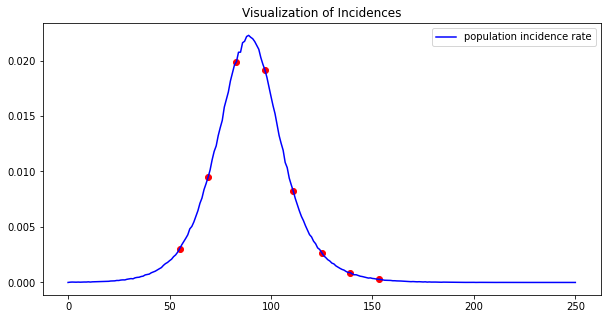

In [5]:
df_sim0_seir_outpus = pd.read_csv("https://raw.githubusercontent.com/pargaw/pyCt/main/Data/Scenario_0/Simulation__seir_outputs_1.csv")
sim0_incs = np.array(df_sim0_seir_outpus["inc"])
N = 1000000

# visualize results
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # make a figure with one row and one column of size 10x5

# Plot the prior samples
ax.plot(np.arange(len(sim0_incs)), sim0_incs / N, color='blue', label='population incidence rate')
# Plot test times
ax.scatter(test_times_0, sim0_incs[test_times_0] / N, color='red')

ax.set_title('Visualization of Incidences')
ax.legend(loc='best')

plt.savefig('scenario0_inc.pdf')
files.download('scenario0_inc.pdf') 

plt.show() # display the figure

In [ ]:
plot_gp_preds_for_times(gp_all_samples, test_times_0, true_rates_0, sim0_incs)

### Scenario 1
---
#### Inference
---

In [6]:
df_sim1_1 = pd.read_csv('https://raw.githubusercontent.com/pargaw/pyCt/main/Data/Scenario_1/Simulation__cts_1.csv')
df_sim1_2 = pd.read_csv('https://raw.githubusercontent.com/pargaw/pyCt/main/Data/Scenario_1/Simulation__cts_2.csv')
# test times for both ct distributions are the same
test_times_1 = df_sim1_1['t'].unique()

In [ ]:
all_num_undecetables_1, all_cts_cross_sections_1, all_split_indices_1 = compute_all_cross_sections_and_splits(df_sim1_1, test_times_1, df_sim1_2)

In [ ]:
all_split_indices_1

[array([   0, 1097]),
 array([   0, 1097, 1563]),
 array([   0, 1097, 1563, 2086]),
 array([   0, 1097, 1563, 2086, 2796]),
 array([   0, 1097, 1563, 2086, 2796, 3412]),
 array([   0, 1097, 1563, 2086, 2796, 3412, 3746]),
 array([   0, 1097, 1563, 2086, 2796, 3412, 3746, 3886]),
 array([   0, 1097, 1563, 2086, 2796, 3412, 3746, 3886, 3947])]

In [ ]:
gp_model_1 = build_gp_model_multiple_sections(test_times_1, all_cts_cross_sections_1[-1], all_split_indices_1[-1])
trace = sample_with_gp_model(gp_model_1, n=500)
gp_mean_1, gp_samples_1 = burn_and_thin_gp(trace)

In [ ]:
df = pd.DataFrame(data=gp_samples_1)
df.to_csv('gp_1_samples.csv')

In [ ]:
gp_all_means_1, gp_all_samples_1 = run_inference_gp_model(test_times_1, all_cts_cross_sections_1, all_split_indices_1)

#### Comparison
---

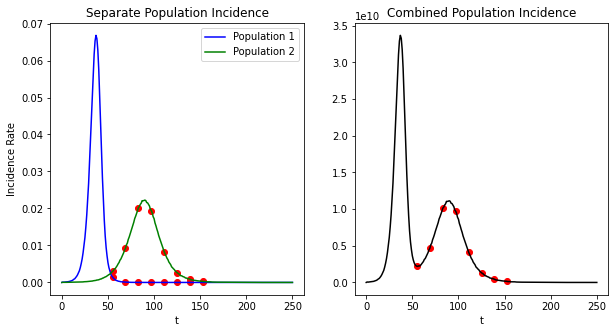

In [7]:
df_sim1_seir_1 = pd.read_csv("https://raw.githubusercontent.com/pargaw/pyCt/main/Data/Scenario_1/Simulation__seir_outputs_1.csv")
df_sim1_seir_2 = pd.read_csv("https://raw.githubusercontent.com/pargaw/pyCt/main/Data/Scenario_1/Simulation__seir_outputs_2.csv")
sim1_1_incs = np.array(df_sim1_seir_1["inc"])
sim1_2_incs = np.array(df_sim1_seir_2["inc"])
N1 = 1000000

# visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5)) # make a figure with one row and one column of size 10x5

# Plot the prior samples
ax[0].plot(np.arange(len(sim1_1_incs)), sim1_1_incs / N, color='blue', label='Population 1')
ax[0].plot(np.arange(len(sim1_2_incs)), sim1_2_incs / N, color='green', label='Population 2')
# Plot test times
ax[0].scatter(test_times_1, sim1_1_incs[test_times_1] / N, color='red')
ax[0].scatter(test_times_1, sim1_2_incs[test_times_1] / N, color='red')

# Plot the prior samples
ax[1].plot(np.arange(len(sim1_1_incs)), (sim1_1_incs + sim1_2_incs) / 2*N, color='black', label='Combined Population')
# Plot test times
ax[1].scatter(test_times_1, (sim1_1_incs[test_times_1] + sim1_2_incs[test_times_1]) / 2*N, color='red')

ax[0].set_title('Separate Population Incidence')
ax[1].set_title('Combined Population Incidence')
ax[0].set_xlabel('t')
ax[1].set_xlabel('t')
ax[0].set_ylabel('Incidence Rate')
ax[0].legend(loc='best')
# ax[1].legend(loc='best')

plt.savefig('scenario1_inc.pdf')
files.download('scenario1_inc.pdf') 

plt.show() # display the figure

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # make a figure with one row and one column of size 10x5

# getting posterior predictive mean and confidence intervals (posterior predictive is incidence rate)
# we treat day 20 in incidence as day 0 in prediction
xs = np.arange(20, 153)
post_test = gp_samples_1
current_incidence_rate = np.array([calculate_gp_numpy(draw) for draw in post_test][::10])

true_incs = (sim1_1_incs + sim1_2_incs) / 2*N1
true_incidence_rates = true_incs[xs] / sum(true_incs[xs])
# scatter incidence rates
ax.scatter(xs, true_incidence_rates, color='black', label='true incidence rate')
for draw in current_incidence_rate:
  # fitting the GP
  ax.plot(xs, draw, color='#C8A2C8', alpha=0.1)
ax.plot([],[], color='#C8A2C8', label='posterior draw of $f$')

ax.set_xlabel('time')
ax.set_ylabel('incidence rate')
ax.set_title('Visualization of Average Growth Rate Prediction from GP Prior Model')
ax.legend(loc='best')

plt.savefig('gp_1.pdf')
files.download('gp_1.pdf')
plt.show() # display the figure

In [ ]:
df_sim1_seir_1 = pd.read_csv("https://raw.githubusercontent.com/pargaw/pyCt/main/Data/Scenario_1/Simulation__seir_outputs_1.csv")
df_sim1_seir_2 = pd.read_csv("https://raw.githubusercontent.com/pargaw/pyCt/main/Data/Scenario_1/Simulation__seir_outputs_2.csv")
sim1_1_incs = np.array(df_sim1_seir_1["inc"])
sim1_2_incs = np.array(df_sim1_seir_2["inc"])
N1 = 1000000

In [ ]:
plot_gp_preds_for_times(gp_all_samples_1, test_times_1, [], (sim1_1_incs + sim1_2_incs) / 2*N1)

### Scenario 2
---

In [8]:
df_sim2_1 = pd.read_csv('https://raw.githubusercontent.com/pargaw/pyCt/main/Data/Scenario_2/Simulation__cts_1.csv')
df_sim2_2 = pd.read_csv('https://raw.githubusercontent.com/pargaw/pyCt/main/Data/Scenario_2/Simulation__cts_2.csv')
# test times for both ct distributions are the same
test_times_2 = df_sim2_1['t'].unique()
# shift population 2 times by 250 days
test_times_2_modified = np.hstack((test_times_2, (test_times_2 + 250)))
test_times_generation = np.hstack((test_times_2[4:], test_times_2[:4]))
test_times_2_inference = test_times_2_modified[4:12] - 56

In [9]:
crop_df1 = df_sim2_1[df_sim2_1['t'].isin(test_times_2[4:])]
crop_df2 = df_sim2_2[df_sim2_2['t'].isin(test_times_2[:4])]
combined_df = pd.concat([crop_df1, crop_df2])
combined_df.head()

,t,ct
7820,111,40.0
7821,111,40.0
7822,111,40.0
7823,111,40.0
7824,111,40.0


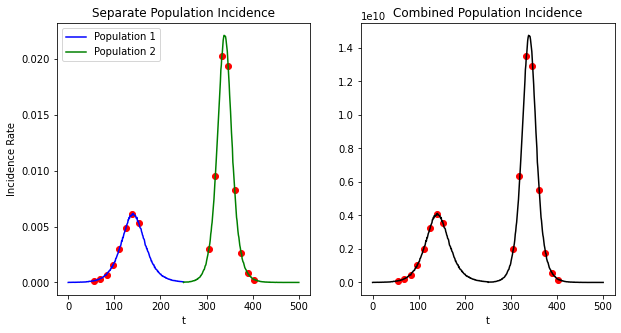

In [10]:
df_sim2_seir_1 = pd.read_csv("https://raw.githubusercontent.com/pargaw/pyCt/main/Data/Scenario_2/Simulation__seir_outputs_1.csv")
df_sim2_seir_2 = pd.read_csv("https://raw.githubusercontent.com/pargaw/pyCt/main/Data/Scenario_2/Simulation__seir_outputs_2.csv")
sim2_1_incs = np.array(df_sim2_seir_1["inc"])
sim2_2_incs = np.array(df_sim2_seir_2["inc"])
total_incs = np.hstack((sim2_1_incs, sim2_2_incs))
N2 = 1000000

# visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5)) # make a figure with one row and one column of size 10x5

# Plot the prior samples
ax[0].plot(np.arange(len(sim2_1_incs)), sim2_1_incs / N, color='blue', label='Population 1')
ax[0].plot(np.arange(250, len(sim2_2_incs) + 250), sim2_2_incs / N, color='green', label='Population 2')
# Plot test times
ax[0].scatter(test_times_2, sim2_1_incs[test_times_2] / N, color='red')
ax[0].scatter(test_times_2 + 250, sim2_2_incs[test_times_2] / N, color='red')

# Plot the prior samples
ax[1].plot(np.arange(len(total_incs)), total_incs / 1.5*N, color='black', label='Combined Population')
# Plot test times
ax[1].scatter(test_times_2, sim2_1_incs[test_times_2] / 1.5*N, color='red')
ax[1].scatter(test_times_2 + 250, sim2_2_incs[test_times_2] / 1.5*N, color='red')

ax[0].set_title('Separate Population Incidence')
ax[1].set_title('Combined Population Incidence')
ax[0].set_xlabel('t')
ax[1].set_xlabel('t')
ax[0].set_ylabel('Incidence Rate')
ax[0].legend(loc='best')

plt.savefig('scenario2_inc.pdf')
files.download('scenario2_inc.pdf') 

plt.show() # display the figure

In [ ]:
num_undecetables_2, cts_cross_sections_2, split_indices_2 = compute_all_cross_sections_and_splits(combined_df, test_times_generation)

In [ ]:
split_indices_2

[array([  0, 120]),
 array([  0, 120, 360]),
 array([  0, 120, 360, 762]),
 array([   0,  120,  360,  762, 1225]),
 array([   0,  120,  360,  762, 1225, 1261]),
 array([   0,  120,  360,  762, 1225, 1261, 1410]),
 array([   0,  120,  360,  762, 1225, 1261, 1410, 1822]),
 array([   0,  120,  360,  762, 1225, 1261, 1410, 1822, 2559])]

In [ ]:
test_times_2_inference

array([ 55,  69,  83,  97, 249, 263, 277, 291])

In [ ]:
gp_model_2 = build_gp_model_multiple_sections(test_times_2_inference, cts_cross_sections_2[-1], split_indices_2[-1])
trace = sample_with_gp_model(gp_model_2, n=500)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [f_rotated_]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2992 seconds.


In [ ]:
gp_mean_2, gp_samples_2 = burn_and_thin_gp(trace)

In [ ]:
df = pd.DataFrame(data=gp_samples_2)
df.to_csv('gp_2_samples.csv')
files.download('gp_2_samples.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plotting_times = np.array([55,  69,  83,  97, 249, 263, 277, 291]) + 56

In [ ]:
plotting_times

array([111, 125, 139, 153, 305, 319, 333, 347])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

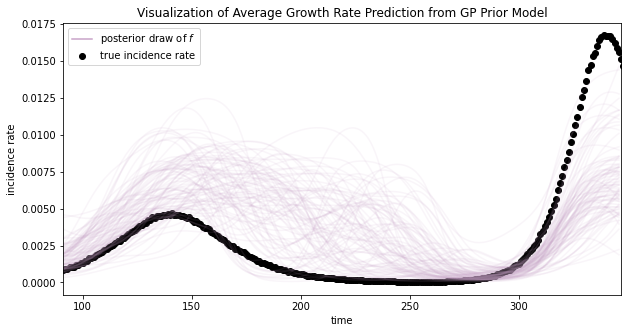

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5)) # make a figure with one row and one column of size 10x5

# getting posterior predictive mean and confidence intervals (posterior predictive is incidence rate)
# we treat day 20 in incidence as day 0 in prediction
xs = np.arange(347 - len(gp_samples_2[0]), 347)
post_test = gp_samples_2
current_incidence_rate = np.array([calculate_gp_numpy(draw) for draw in post_test][::10])

new_incs = np.hstack((sim2_1_incs, sim2_2_incs))
true_incs = new_incs / (1.5 * N2)
true_incidence_rates = true_incs / sum(true_incs)
# scatter incidence rates
ax.scatter(np.arange(len(true_incidence_rates)), true_incidence_rates, color='black', label='true incidence rate')
for draw in current_incidence_rate:
  # fitting the GP
  ax.plot(xs, draw, color='#C8A2C8', alpha=0.1)
ax.plot([],[], color='#C8A2C8', label='posterior draw of $f$')

ax.set_xlabel('time')
ax.set_ylabel('incidence rate')
ax.set_title('Visualization of Average Growth Rate Prediction from GP Prior Model')
ax.legend(loc='best')
ax.set_xlim(91, 347)

plt.savefig('gp_2.pdf')
files.download('gp_2.pdf')

plt.show() # display the figure

### Scenario 3
---

In [11]:
df_sim3_1 = pd.read_csv('https://raw.githubusercontent.com/pargaw/pyCt/main/Data/Scenario_3/Simulation__cts_1.csv')
df_sim3_2 = pd.read_csv('https://raw.githubusercontent.com/pargaw/pyCt/main/Data/Scenario_3/Simulation__cts_2.csv')
# test times for both ct distributions are the same
test_times_3 = df_sim3_1['t'].unique()

In [ ]:
all_num_undecetables_3, all_cts_cross_sections_3, all_split_indices_3 = compute_all_cross_sections_and_splits(df_sim3_1, test_times_3, df_sim3_2)

In [ ]:
all_split_indices_3

[array([ 0, 14]),
 array([  0,  14, 235]),
 array([  0,  14, 235, 788]),
 array([   0,   14,  235,  788, 1671]),
 array([   0,   14,  235,  788, 1671, 2630]),
 array([   0,   14,  235,  788, 1671, 2630, 3417]),
 array([   0,   14,  235,  788, 1671, 2630, 3417, 3990]),
 array([   0,   14,  235,  788, 1671, 2630, 3417, 3990, 4380])]

In [ ]:
gp_all_means_3, gp_all_samples_3 = run_inference_gp_model(test_times_3, all_cts_cross_sections_3, all_split_indices_3)

Executing inference for cross section t = 55


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [f_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


Executing inference for cross section t = 69


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [f_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.


Executing inference for cross section t = 83


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [f_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 183 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Executing inference for cross section t = 97


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [f_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 500 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Executing inference for cross section t = 111


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [f_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 868 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Executing inference for cross section t = 125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [f_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1799 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Executing inference for cross section t = 139


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [f_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2356 seconds.


Executing inference for cross section t = 153


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [f_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3347 seconds.


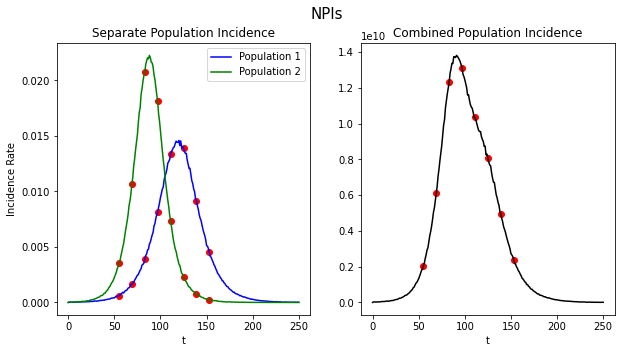

In [14]:
df_sim3_seir_1 = pd.read_csv("https://raw.githubusercontent.com/pargaw/pyCt/main/Data/Scenario_3/Simulation__seir_outputs_1.csv")
df_sim3_seir_2 = pd.read_csv("https://raw.githubusercontent.com/pargaw/pyCt/main/Data/Scenario_3/Simulation__seir_outputs_2.csv")

sim3_1_incs = np.array(df_sim3_seir_1["inc"])
sim3_2_incs = np.array(df_sim3_seir_2["inc"])
N3 = 1000000

# visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5)) # make a figure with one row and one column of size 10x5

# Plot the prior samples
ax[0].plot(np.arange(len(sim3_1_incs)), sim3_1_incs / N3_1, color='blue', label='Population 1')
ax[0].plot(np.arange(len(sim3_2_incs)), sim3_2_incs / N3_2, color='green', label='Population 2')
# Plot test times
ax[0].scatter(test_times_3, sim3_1_incs[test_times_3] / N3_1, color='red')
ax[0].scatter(test_times_3, sim3_2_incs[test_times_3] / N3_2, color='red')

# Plot the prior samples
ax[1].plot(np.arange(len(sim3_1_incs)), (sim3_1_incs + sim3_2_incs) / 2*N3_1, color='black', label='Combined Population')
# Plot test times
ax[1].scatter(test_times_3, (sim3_1_incs[test_times_3] + sim3_2_incs[test_times_3]) / 2*N3_1, color='red')

ax[0].set_title('Separate Population Incidence')
ax[1].set_title('Combined Population Incidence')
ax[0].set_xlabel('t')
ax[1].set_xlabel('t')
ax[0].set_ylabel('Incidence Rate')
ax[0].legend(loc='best')

plt.suptitle('NPIs', size=15)

plt.savefig('scenario3_inc.pdf')
files.download('scenario3_inc.pdf') 

plt.show() # display the figure

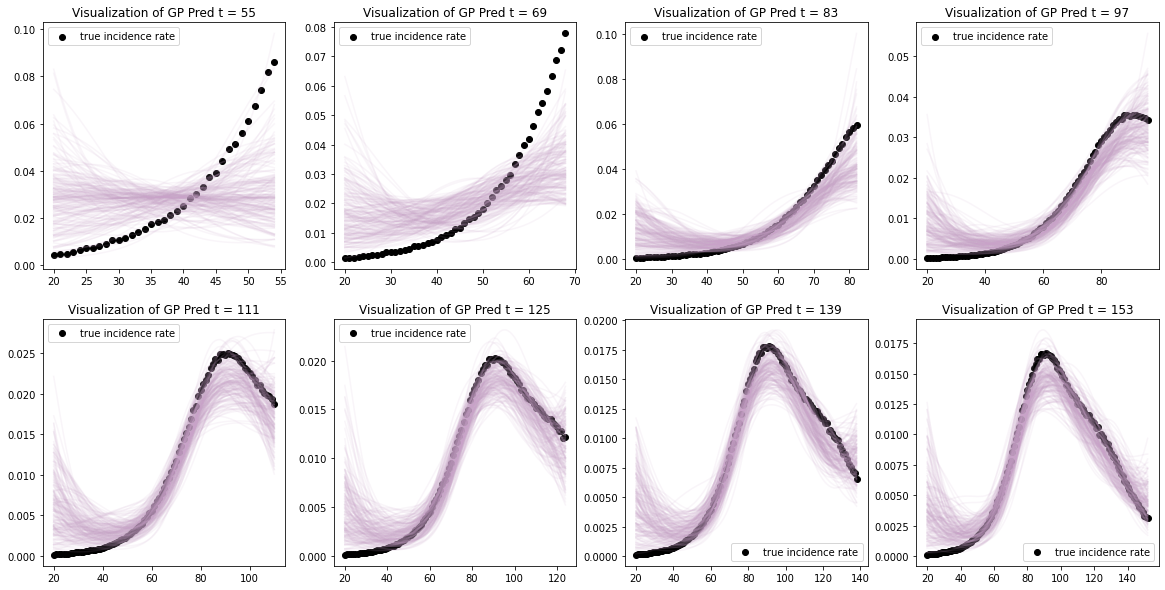

In [ ]:
plot_gp_preds_for_times(gp_all_samples_3, test_times_3, [], (sim3_1_incs + sim3_2_incs) / 2*N3)